In [42]:
import pandas as pd
import math
import os

In [43]:
wd = os.getcwd()
data_path = wd + "/data/"
for doc in os.listdir(data_path):
    print(doc)

reddit-braincels-posts.anon.txt
reddit-incel-posts.anon.txt
reddit-IncelExit-posts.anon.txt


In [104]:
import pandas as pd

rows = []
with open(data_path + "reddit-braincels-posts.anon.txt", "r", encoding="utf-8", errors="replace") as f:
    for line in f:
        line = line.rstrip("\n")
        if not line or line.startswith(("link\t","url\t")):
            continue  # skip the two header-ish lines
        parts = line.split("\t", 6)  # at most 7 columns
        # pad to length 7
        if len(parts) < 7:
            parts += [""] * (7 - len(parts))
        rows.append(parts)

df = pd.DataFrame(rows, columns=["ref","comment_id","user_id","parent","timestamp","title","text"])

# Optional: clean literal \n sequences inside text/title
df["title"] = df["title"].str.replace("\\n", "\n")
df["text"]  = df["text"].str.replace("\\n", "\n")

# Optional: timestamp
df["timestamp_dt"] = pd.to_datetime(df["timestamp"], unit="s", errors="coerce")


C:\Users\Andreas\AppData\Local\Temp\ipykernel_22372\1977557338.py:22: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp_dt"] = pd.to_datetime(df["timestamp"], unit="s", errors="coerce")


In [105]:
len(df)

2408205

In [106]:
df.head()

,ref,comment_id,user_id,parent,timestamp,title,text,timestamp_dt
0,https://www.reddit.com/r/Braincels/comments/77...,77ru0b,924979030.686585,,1508566505,Getting Settled in,"""General discussion and Q&amp;A thread since w...",2017-10-21 06:15:05
1,/r/Braincels/comments/doqectl/comment/doqgmkg,doqgmkg,931484113.951227,doqectl,1508701504,,Thanks. It just seemed that it would be anothe...,2017-10-22 19:45:04
2,/r/Braincels/comments/doqe6l5/comment/doqectl,doqectl,924979030.686585,doqe6l5,1508699066,,"""To your last question, of course your safe he...",2017-10-22 19:04:26
3,/r/Braincels/comments/doqds16/comment/doqe6l5,doqe6l5,931484113.951227,doqds16,1508698882,,Do you agree with Marx’s view on women?\n\nI’m...,2017-10-22 19:01:22
4,/r/Braincels/comments/doqcx0s/comment/doqds16,doqds16,924979030.686585,doqcx0s,1508698449,,"I tend to just call myself a """"socialist"""". I\...",2017-10-22 18:54:09


In [47]:
incels_reduced = df  # Define this first
incels_reduced_small = incels_reduced.copy()  # Work with a copy
incels_reduced_small.fillna(False, inplace=True)

C:\Users\Andreas\AppData\Local\Temp\ipykernel_22372\3098934956.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  incels_reduced_small.fillna(False, inplace=True)


In [48]:
incels_reduced = df  # Define this first
incels_reduced_small = incels_reduced.copy()  # Work with a copy
incels_reduced_small.fillna(False, inplace=True)

chats = {}
edges = []
nodes = set()
node_attributes = {}

# First pass: Add all root posts (posts with titles)
for idx, row in incels_reduced_small.iterrows():
    link, c_id, u_id, p_id, timestamp, title, text, ts = row
    if p_id == '':  # This is a root post
        chats[c_id] = {
            'text': text,
            'user_id': u_id,
            'childs': []
        }

        if node_attributes.get(u_id):
            node_attributes[u_id]['posts'].append(text)
        else:
            node_attributes[u_id] = {
                'posts': [text]
            }
        nodes.add(u_id)

print(f"Root posts found: {len(chats)}")

# Multiple passes to handle parent-child relationships
max_iterations = 10
iteration = 0


while not incels_reduced_small.empty and iteration < max_iterations:
    indices_to_drop = []
    incels_reduced_small = incels_reduced_small.iloc[::-1]
    for idx, row in incels_reduced_small.iterrows():
        link, c_id, u_id, p_id, timestamp, title, text, ts = row
        
        # Skip if already processed (root posts)
        if c_id in chats:
            indices_to_drop.append(idx)
            continue
            
        # Process if parent exists in chats
        if p_id in chats:
            chats[c_id] = {
                'text': text,
                'user_id': u_id,
                'childs': [],
                'parent': p_id
            }   
            chats[p_id]['childs'].append(c_id)
            if chats[p_id]['user_id'] != u_id: # Avoid self-loops
                edges.append((u_id, chats[p_id]['user_id'])) 
            nodes.add(u_id)

            if node_attributes.get(u_id):
                node_attributes[u_id]['posts'].append(text)
            else:
                node_attributes[u_id] = {
                    'posts': [text]
                }
            indices_to_drop.append(idx)
    
    print(f"Iteration {iteration + 1}: Processing {len(indices_to_drop)} comments")
    
    
    if not indices_to_drop:
        print("No more comments can be processed - breaking")
        break   
    
    incels_reduced_small = incels_reduced_small.drop(index=indices_to_drop)
    print(f"Remaining rows: {len(incels_reduced_small)}")
    iteration += 1

print(f"\nFinal results:")
print(f"Total comments processed: {len(chats)}")
print(f"Total edges created: {len(edges)}")


C:\Users\Andreas\AppData\Local\Temp\ipykernel_22372\1875695477.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  incels_reduced_small.fillna(False, inplace=True)


Root posts found: 4747
Iteration 1: Processing 110738 comments
Remaining rows: 390
Iteration 2: Processing 0 comments
No more comments can be processed - breaking

Final results:
Total comments processed: 110583
Total edges created: 77134


In [49]:
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)


In [50]:
# node_with_5_posts = [node for node in G.nodes(data=True) if len(node['posts']) >= 5]
for key, value in node_attributes.items():
    if len(value['posts']) >= 5:
        node_attributes[key]['n_posts'] = len(value['posts'])

In [51]:
nx.set_node_attributes(G, node_attributes)

In [52]:
subgraph_nodes = [node for node, attr in G.nodes(data=True) if attr.get('n_posts', 0) >= 10]
subgraph_ = G.subgraph(subgraph_nodes).copy()

In [53]:
len(subgraph_.nodes)

928

In [101]:
len(subgraph_.edges)

7729

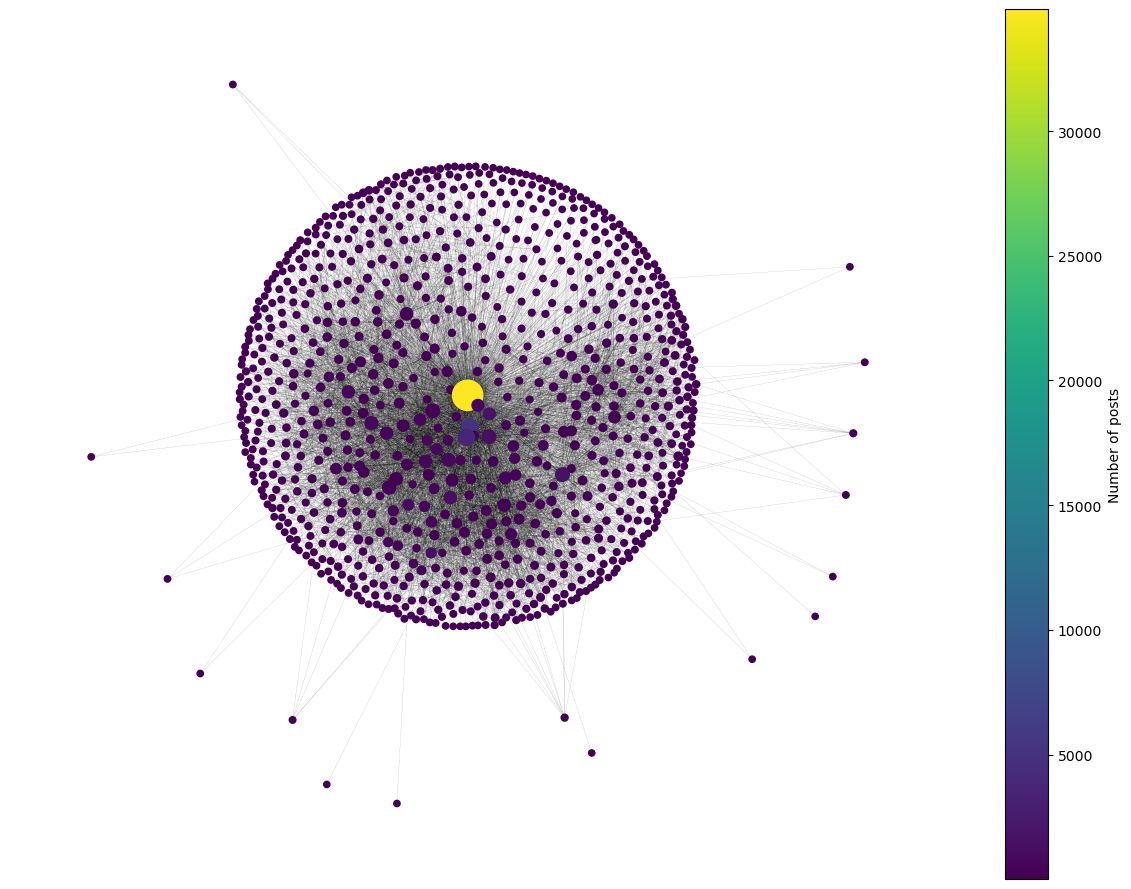

In [99]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 9))

undirected_subgraph = subgraph_.to_undirected()
n = undirected_subgraph.number_of_nodes()

spring_pos = nx.spring_layout(
                    undirected_subgraph, 
                    k=5)

pos = nx.kamada_kawai_layout(
    undirected_subgraph, 
    pos=spring_pos, 
    weight=None, 
    scale=20
)
deg = dict(undirected_subgraph.degree())
node_sizes = [20 + deg.get(n, 0)*0.5 for n in undirected_subgraph.nodes()]  # base size + scale factor
n_posts = [undirected_subgraph.nodes[n].get('n_posts', 0) for n in undirected_subgraph.nodes()]

cmap = plt.cm.viridis

nodes = nx.draw_networkx_nodes(undirected_subgraph, pos,
                       node_size=node_sizes,
                       node_color=n_posts,
                       cmap=cmap)
nx.draw_networkx_edges(undirected_subgraph, pos, width=0.1, alpha=0.5)

colorbar = plt.colorbar(nodes)
colorbar.set_label('Number of posts')
plt.tight_layout()
plt.axis('off')
plt.show()

In [100]:
# show top 5 posters (by occurrences in df) and also from node_attributes if available
top_from_df = df['user_id'].value_counts().head(5)
print("Top 5 posters (from df):")
print(top_from_df)

# if node_attributes exists, show top 5 by collected posts there (counts from stored posts lists)
if 'node_attributes' in globals():
    top_from_nodes = sorted(
        ((uid, len(attrs.get('posts', []))) for uid, attrs in node_attributes.items()),
        key=lambda x: x[1], reverse=True
    )[:5]
    print("\nTop 5 posters (from node_attributes):")
    for i, (uid, cnt) in enumerate(top_from_nodes, 1):
        print(f"{i}. {uid}: {cnt} posts")

Top 5 posters (from df):
user_id
924980486.069293    35004
924998581.49679      5112
925006802.224807     3762
925489165.095947     1742
925973704.552935     1528
Name: count, dtype: int64

Top 5 posters (from node_attributes):
1. 924980486.069293: 34892 posts
2. 924998581.49679: 5079 posts
3. 925006802.224807: 3755 posts
4. 925489165.095947: 1742 posts
5. 925973704.552935: 1522 posts


In [ ]:
subgraph_nodes

IndexError: string index out of range